In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
from scipy.linalg import cholesky
from pandas import bdate_range   # business days
# Original code source: http://yasermartinez.com/blog/posts/brownian-simulation-of-correlated-assets.html
# Objective: Use MC to price a derivative instrument dependant on a basket of underlying.
# "How to" Method: Implement multidimensional stochastic simulation while maintaining correlations between underlying assets
# STOCHASTIC CALCULUS MATH: ==> stochastic differential equation
# S{t+∆t}=S{t}*exp⁡(μ−σ^2/2)*∆t+σ*SqRt(Δt)*W{t}  # => Brownian motion path W 
# dX{t} = 0.5*(sigma^2)*X{t}*dt +sigma*X{t}*dWt => dX{t} = (mu - 0.5*sigma^2)t + sigma*W{t}, etc. etc. see the paper...
# More math: http://www.math.nyu.edu/faculty/goodman/teaching/StochCalc2012/notes/Week9.pdf

symbols = ["AAPL","MSFT","NFLX","MCD","GE","AIG","HIG"]
# d1 is a pandas dataframe with stock prices loaded fromm Quandl and saved as a pickle
d1 = pickle.load(open("/home/ubuntu/portfolio/factors/stock_data.pkl","rb"))
d2 = d1[d1["ticker"].isin(symbols)][["Close","ticker"]]
closing = d2.reset_index().pivot(index="Date", columns='ticker', values='Close') #[-252:] 
closing =  closing[closing.index >="2010-01-04"] # Start time series from 2010-01-04
rets = np.log(closing / closing.shift(1)).dropna()
corr_matrix = rets.corr()

In [2]:
# Config data for MC simulations...
n_days = 21
dates = bdate_range(start=closing.iloc[-1].name, periods=n_days)
n_assets = len(symbols)
n_sims = 1000
dt = 1./252
mu = rets.mean().values
sigma = rets.std().values*np.sqrt(252)
np.random.seed(1234)            # init random number generator for reproducibility
upper_cholesky = cholesky(corr_matrix, lower=False) #Cholesky Decomposition matrix
# 3.2. Generate random vector X satisfying N(0,1) / generate the correlated random values X https://www.oswego.edu/~srp/stats/z.htm
rand_values = np.random.standard_normal(size = (n_days * n_sims, n_assets)) # N-values matrix [Y,X] => (21000, 7)
# 3.3. Correlated random vector Z = X*L{T}  => W{t} * σ  # W{t}= random matrix * cholesky matrix => Brownian motion path
corr_values = rand_values.dot(upper_cholesky)*sigma # matrix multiplication, i.e. np.dot(rand_values,upper_cholesky)

In [3]:
sims = {}
df1 = pd.DataFrame(data = np.zeros([n_days,len(symbols)]), index=dates, columns=symbols) # (21,7)
for sym in symbols:
    df1.iloc[0,:][sym] = closing.iloc[-1][sym] # assign last day price to base row
for n in range(n_sims):
    df2 = df1.copy()
    for i in range(1,n_days):
        # matrix shape of [n-tickers, # of simulations] for each day   # corr_values @(21000, 7)
        # S{t+∆t}=S{t}*exp⁡(μ−σ^2/2)*∆t+SqRt(Δt)*σ*W{t}
        eachday_sim_matrix = (np.exp((mu-0.5*sigma**2)*dt +  np.sqrt(dt)*corr_values[i::n_days]))[n]  # (1000,7)  => (1,7)
        df2.iloc[i,:]= df2.iloc[i-1,:]*eachday_sim_matrix # MC sim updated price path from T-0 to T-n days
    sims[n] = df2 

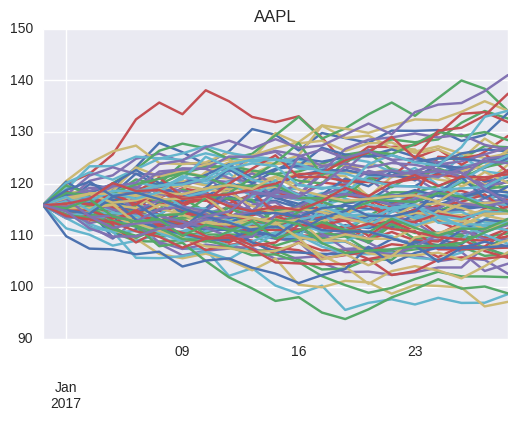

In [4]:
# Display every 10th simulation path for Apple stock price
for i in range(0,n_sims,10):
    if i == 0:
        df3 = sims[i]["AAPL"]
    else:
        df3 = pd.concat([df3,sims[i]["AAPL"]], axis=1)
df3.plot(title='AAPL', legend=False) 

In [5]:
# Correlation matrix check:to ensure correlations have persisted throughout price path simulations
rets = np.zeros((n_sims,len(sims[0])-1,len(symbols)))
for i in range(0,n_sims):
    simulated_prices = sims[i] 
    predicted_rets = np.log(simulated_prices / simulated_prices.shift(1)).dropna()
    rets[i] = predicted_rets.values 
# Average returns for each ticker and find correlation of the simulated returns.. [to compare with the original correlations]
mean_predicted_rets = rets.mean(0)   
corr_matrix_after_sims = pd.DataFrame(mean_predicted_rets, columns=symbols).corr()
corr_matrix_after_sims

,AAPL,MSFT,NFLX,MCD,GE,AIG,HIG
AAPL,1.000000,0.423550,0.428800,0.525323,0.575462,0.299715,0.042124
MSFT,0.423550,1.000000,0.518845,0.680199,0.059573,0.232787,-0.120449
NFLX,0.428800,0.518845,1.000000,0.696264,0.467716,0.563605,-0.372196
MCD,0.525323,0.680199,0.696264,1.000000,0.477075,0.384507,-0.373198
GE,0.575462,0.059573,0.467716,0.477075,1.000000,0.265353,-0.409976
AIG,0.299715,0.232787,0.563605,0.384507,0.265353,1.000000,-0.256896
HIG,0.042124,-0.120449,-0.372196,-0.373198,-0.409976,-0.256896,1.000000


In [6]:
# ORIGINAL Correlation Matrix
corr_matrix

ticker,AAPL,AIG,GE,HIG,MCD,MSFT,NFLX
ticker,,,,,,,
AAPL,1.000000,0.339635,0.385456,0.374741,0.322861,0.393205,0.088613
AIG,0.339635,1.000000,0.519447,0.619234,0.337377,0.388262,0.100907
GE,0.385456,0.519447,1.000000,0.630573,0.461966,0.475482,0.107594
HIG,0.374741,0.619234,0.630573,1.000000,0.404392,0.453004,0.092625
MCD,0.322861,0.337377,0.461966,0.404392,1.000000,0.414139,0.078100
MSFT,0.393205,0.388262,0.475482,0.453004,0.414139,1.000000,0.114909
NFLX,0.088613,0.100907,0.107594,0.092625,0.078100,0.114909,1.000000


In [7]:
closing.describe()  # describe original time series

ticker,AAPL,AIG,GE,HIG,MCD,MSFT,NFLX
count,1762.000000,1749.000000,1762.000000,1762.000000,1762.000000,1762.000000,1762.000000
mean,312.926817,44.547973,23.151579,31.542507,94.499595,37.129517,210.245150
std,185.147357,12.293802,4.884828,9.669804,15.031209,10.810791,146.810924
min,90.280000,20.070000,13.880000,14.920000,61.450000,23.010000,49.130000
25%,115.191250,34.110000,19.020000,23.442500,87.082500,27.840000,97.587500
50%,318.240000,46.830000,23.605000,30.710000,95.315000,33.025000,142.339950
75%,472.592500,55.010000,26.770000,41.007500,100.080000,46.107500,318.155000
max,702.100000,66.700000,32.930000,49.530000,131.600000,63.620000,707.610000


In [8]:
# Describe mean of the simulated time-series paths
# Find Monte Carlo path mean PXs
simPXs = np.zeros((n_sims,len(sims[0]),len(symbols)))
for i in range(0,n_sims):
    simPXs[i] = sims[i] #.values 
meanSimPXs = pd.DataFrame(data=simPXs.mean(0), columns=symbols)
meanSimPXs.describe()

,AAPL,MSFT,NFLX,MCD,GE,AIG,HIG
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,116.222132,62.134649,123.634566,121.798390,31.589123,65.267872,47.513837
std,0.224900,0.049199,0.104928,0.105810,0.013853,0.034546,0.117993
min,115.850000,62.054791,123.465898,121.558020,31.556491,65.215119,47.368480
25%,116.084938,62.097295,123.555483,121.720000,31.582953,65.248087,47.445951
50%,116.231332,62.140192,123.606122,121.812048,31.591207,65.257707,47.473193
75%,116.440398,62.167536,123.728525,121.888993,31.596635,65.294943,47.556709
max,116.536246,62.220547,123.800000,121.975030,31.610501,65.331350,47.786710
